# Create Line shapefile from CSV File 

* Purpose of script: Create a shapefile to visualize the flow network
* Author: Rutger Hofste
* Kernel used: python35
* Date created: 20171009

In [1]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version
%matplotlib inline

Y2017M10D10 UTC 07:05


In [2]:
INPUT_VERSION = 1
OUTPUT_VERSION = 1

S3_INPUT_PATH =  "s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/"
S3_OUTPUT_PATH = "s3://wri-projects/Aqueduct30/processData/Y2017M10D09_RH_create_Line_Shape_File_V01/output/"

INPUT_FILE_NAME = "hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V%0.2d" %(INPUT_VERSION)
OUTPUT_FILE_NAME = "Y2017M10D09_RH_create_Line_Shape_File_V%s.shp" %(OUTPUT_VERSION)

EC2_INPUT_PATH = "/volumes/data/Y2017M10D09_RH_create_Line_Shape_File_V01/input"
EC2_OUTPUT_PATH = "/volumes/data/Y2017M10D09_RH_create_Line_Shape_File_V01/output"


In [3]:
!rm -r {EC2_INPUT_PATH} 
!rm -r {EC2_OUTPUT_PATH} 

In [4]:
!mkdir -p {EC2_INPUT_PATH} 
!mkdir -p {EC2_OUTPUT_PATH} 

In [5]:
!aws s3 cp {S3_INPUT_PATH} {EC2_INPUT_PATH} --recursive

download: s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.cpg to ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/input/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.cpg
download: s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.prj to ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/input/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.prj
download: s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.shx to ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/input/hybas_lev06_v1c_merged_fiona_upstream_downstream_FAO_V01.shx
download: s3://wri-projects/Aqueduct30/processData/Y2017M08D29_RH_Merge_FAONames_Upstream_V01/output/hybas_lev06_v1c_merged_fio

In [6]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString


In [7]:
df = pd.read_pickle(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME+".pkl"))

In [8]:
gdf = gpd.read_file(os.path.join(EC2_INPUT_PATH,INPUT_FILE_NAME+".shp"))

In [9]:
gdf = gdf.set_index("PFAF_ID",drop=False)

In [10]:
print(df.shape,gdf.shape)

(16397, 25) (16397, 2)


In [11]:
df = df.drop_duplicates(subset="PFAF_ID",keep='first')

In [12]:
gdf = gdf.drop_duplicates(subset="PFAF_ID",keep='first')

In [13]:
print(df.shape,gdf.shape)

(16396, 25) (16396, 2)


In [14]:
#gdfOut = gdf.copy()

In [15]:
gdf['geometry'] = gdf.geometry.centroid

In [16]:
gdf["centroid_x"] = gdf.geometry.x

In [17]:
gdf["centroid_y"] = gdf.geometry.y

In [18]:
gdf["HYBAS_ID"] = df["HYBAS_ID"]
gdf["NEXT_DOWN"] = df["NEXT_DOWN"]
gdf["ENDO"] = df["ENDO"]


In [19]:
gdf = gdf.set_index("HYBAS_ID",drop=False)   

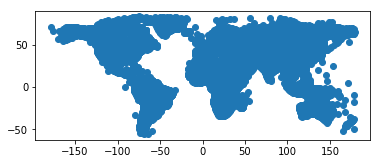

In [20]:
gdf.plot()

In [21]:
for index, row in gdf.iterrows():
    if row["NEXT_DOWN"] != 0 and row["ENDO"] != 2:
        gdf.set_value(index,"next_centroid_x",gdf.loc[row["NEXT_DOWN"]]["centroid_x"])
        gdf.set_value(index,"next_centroid_y",gdf.loc[row["NEXT_DOWN"]]["centroid_y"])
    else:
        gdf.set_value(index,"next_centroid_x",gdf.loc[index]["centroid_x"])
        gdf.set_value(index,"next_centroid_y",gdf.loc[index]["centroid_y"])

In [22]:
def fxy(x, y, xx, yy):
    point1 = Point(x,y)
    point2 = Point(xx,yy)
    geom = LineString([point1,point2])
    return geom

In [23]:
df = gdf.drop("geometry",axis=1)

In [24]:
df.head()

,PFAF_ID,centroid_x,centroid_y,HYBAS_ID,NEXT_DOWN,ENDO,next_centroid_x,next_centroid_y
HYBAS_ID,,,,,,,,
6060000010,611001,-78.013646,8.927000,6060000010,0,0,-78.013646,8.927000
6060000200,611002,-76.765133,6.639787,6060000200,0,0,-76.765133,6.639787
6060000210,611003,-76.909605,7.883699,6060000210,0,0,-76.909605,7.883699
6060000240,611004,-76.645155,7.684698,6060000240,0,0,-76.645155,7.684698
6060000250,611005,-76.438453,8.536851,6060000250,0,0,-76.438453,8.536851


In [25]:
dfSimple = pd.DataFrame(df["PFAF_ID"])

In [26]:
gdfSimple = gpd.GeoDataFrame(dfSimple)

In [27]:
gs = gpd.GeoSeries(index=dfSimple.index)

In [28]:
listje = []
for index, row in df.iterrows():      
    listje.append(fxy(row.centroid_x,row.centroid_y,row.next_centroid_x,row.next_centroid_y) )

In [29]:
#gs = gpd.GeoSeries(df.apply(lambda x: fxy(x['centroid_x'], x['centroid_y'],x['next_centroid_x'],x['next_centroid_y']), axis=1))




In [30]:
gdf_Out2 = gpd.GeoDataFrame(dfSimple,geometry=listje)

In [31]:
gdf_Out2 = gdf_Out2.set_index("PFAF_ID",drop=False)

In [32]:
gdf_Out2.crs = {'init' :'epsg:4326'}

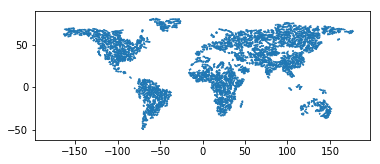

In [33]:
gdf_Out2.plot()

In [34]:
gdf_Out2.to_file(driver = 'ESRI Shapefile', filename = os.path.join(EC2_OUTPUT_PATH,OUTPUT_FILE_NAME))

In [35]:
!aws s3 cp {EC2_OUTPUT_PATH} {S3_OUTPUT_PATH} --recursive

upload: ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.prj to s3://wri-projects/Aqueduct30/processData/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.prj
upload: ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.cpg to s3://wri-projects/Aqueduct30/processData/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.cpg
upload: ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.dbf to s3://wri-projects/Aqueduct30/processData/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.dbf
upload: ../../../../data/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_create_Line_Shape_File_V1.shx to s3://wri-projects/Aqueduct30/processData/Y2017M10D09_RH_create_Line_Shape_File_V01/output/Y2017M10D09_RH_cr